# Uvod

Student: Ivana Zebić IT 36-2020

Predmet: Principi prezentacije i prepoznavanja oblika

Tema projektnog zadatka: Detekcija godina, pola i emocija


---


Duboko učenje je grana mašinskog učenja koja se temelji na modelima neuronskih mreža s više slojeva (tzv. dubokih neuronskih mreža) za automatsko učenje reprezentacija podataka.

**Konvolucijske neuronske mreže (CNN)** su posebno dizajnirane neuronske mreže za obradu slika. One koriste slojeve konvolucije koji se primjenjuju na ulazne slike kako bi izvukli različite značajke (poput rubova, tekstura, ili oblika) iz slike. Konvolucijski filteri, ili "jezgri", prolaze kroz sliku i izračunavaju skalarni proizvod između piksela slike i elemenata filtera. Ovo stvara "mapu značajki" koja sadrži informacije o prisutnosti različitih značajki u slici.

**Slojevi agregacije (Pooling)** se često koriste nakon konvolucijskih slojeva kako bi se smanjila prostorna dimenzionalnost mapa značajki, čime se smanjuje broj parametara u mreži i povećava invarijantnost na translacije.

**Potpuno povezani slojevi (Fully Connected Layers)** se obično koriste na kraju mreže kako bi se klasifikovali izlazi nakon što su izdvojene značajke iz ulaznih slika. Svaki neuron u potpuno povezanom sloju je povezan sa svakim neuronu u prethodnom sloju, što omogućava modelu da nauči složene ne-linearne odnose između značajki.


# Praktični dio

U narednoj ćeliji je prikazan kod za kompletnu proceduru treniranja modela za detekciju pola osobe na slikama korišćenjem transfer learninga na prethodno treniranom VGG16 modelu.

---


Prethodno trenirani VGG16 model se učitava sa težinama naučenim na ImageNet skupu podataka.

Slojevi ovog prethodno treniranog VGG16 modela se "zamrzavaju" postavljanjem trainable = False, što znači da se neće trenirati tokom procesa optimizacije. Ovo se radi da bi se iskoristili naučeni filteri iz prethodnog modela i ubrzalo treniranje.

Na vrh prethodno treniranog modela dodaju se novi slojevi za prilagođavanje modela na specifičan problem.

Slike se pripremaju korišćenjem ImageDataGenerator objekta koji vrši različite transformacije nad slikama kao što su reskaliranje, naginjanje, zumiranje i horizontalno rotiranje.

Trening slike se učitavaju iz direktorijuma "train" korišćenjem "flow_from_directory" metode, a definisani generator se koristi za obradu slika tokom treniranja.

In [2]:
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator

# Učitavanje VGG-Face modela, koji je baziran na ImageNet slikama
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Transfer learning --- Feature extraction, "zamrzavanjem" slojeva, unapređujemo model sa našim setom trening slika, i imamo benefite već istreniranog modela koji možemo primeniti na naš
# slučaj upotrebe.
for layer in base_model.layers:
    layer.trainable = False

# Na slojeve modela dodajemo naš sloj.
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)  # Definišemo sloj za klasifikaciju pola (1 neuron)

# Kombinovanje modela sa našim novim slojem.
model = Model(inputs=base_model.input, outputs=predictions)

# Kompilacija modela pomoću Adam optimizatora (preporučen za rad sa slikama), baziran na SGD (stohastičnom gradijentnom padu)
# lr predstavlja stopu učenja odnosno koliko će model pomerati varijacije prilikom računanja funkcije gubitka (tako da gubitak bude minimiziran).
# i algoritmom gubitka binarne unakrsne entropije, koja je pogodna za probleme binarne klasifikacije (kao što je određivanje pola)
# Kao metrika evaluacije modela izabrana je tačnost umesto preciznosti, zato što su prosleđene slike balansirane, odnosno poseduju sličan broj slika osoba muškog i ženskog pola.
model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Menjanje podataka
train_datagen = ImageDataGenerator(
    rescale=1./255, #Normalizovanje pixela slike na vrednosti između 0 i 1
    shear_range=0.2, #Svaka slika će se nagnuti za 0.2 radijana
    zoom_range=0.2, #Svaka slika će se uvećati ili smanjiti za 20%
    horizontal_flip=True #Postoji 50% šansa da će se slike horizontalno rotirati i imati efekat ogledala.
)


# Učitvanje slika koje se koriste za treniranje
train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

# Treniranje modela
model.fit(
    train_generator,
    epochs=5,  # Broj epoha
    steps_per_epoch=len(train_generator), #Broj koraka u jednoj epohi, odnosno iteracija uzimanja svih slika i pokretanja mreže
    verbose=1
)

# Model se čuva u fajlove na colab-u
model.save('gender_detection_model.h5')


Found 93 images belonging to 5 classes.
Epoch 1/5
3/3 [==============================] - 68s 20s/step - loss: 0.6998 - accuracy: 0.2151
Epoch 2/5
3/3 [==============================] - 60s 18s/step - loss: -1.7169 - accuracy: 0.1828
Epoch 3/5
3/3 [==============================] - 57s 19s/step - loss: -3.9235 - accuracy: 0.1828
Epoch 4/5
3/3 [==============================] - 57s 20s/step - loss: -5.7631 - accuracy: 0.1828
Epoch 5/5
3/3 [==============================] - 57s 19s/step - loss: -7.4221 - accuracy: 0.1828


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Nakon kreiranog modela neophodno je izvršiti njegovo testiranje.

In [3]:
#Instalacija biblioteka
!pip install deepface
!pip install opencv-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.8/87.8 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.4/88.4 kB 8.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.2/80.2 kB 7.2 MB/s eta 0:00:00
  Created wheel for fire: filename=fire-0.6.0-py2.py3-none-any.whl size=117029 sha256=fb6cddca48020cfcb042c8b0d54c4ef955a1fb4c186f36d1d0b846aa9cf54f58
  Stored in directory: /root/.cache/pip/wheels/d6/6d/5d/5b73fa0f46d01a793713f8859201361e9e581ced8c75e5c6a3
Successfully built fire


1/1 [==============================] - 1s 702ms/step
Predicted Gender: Male


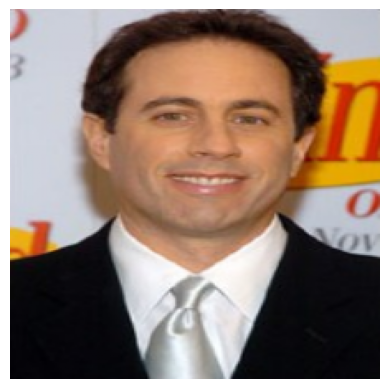

In [4]:
#Testiranje kreiranog modela

import matplotlib.pyplot as plt
from keras.models import load_model
import cv2 #Koristimo CV2 biblioteku da bi mogli da radimo sa slikama
import numpy as np #Numpy biblioteka se poziva radi lakšeg rada sa podacima

# Učitavanje modela
model = load_model('gender_detection_model.h5')

# Probaćemo samo 1 sliku, te je formatiramo sa istim parametrima kao i tokom treninga modela.
test_image_path = '/content/drive/MyDrive/train/jerry_seinfeld/httpgraphicsnytimescomimagessectionmoviesfilmographyWireImagejpg.jpg'
img = cv2.imread(test_image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (224, 224))

# Normalizacija pixel vrednosti na 0 do 1 (brži rad modela sa slikama)
img = img / 255.0

# Dodavanje dimenzija koje model očekuje (test slika poseduje 3 dimenzije, a model očekuje 4)
img = np.expand_dims(img, axis=0)

# Predikcija
predictions = model.predict(img)

predicted_class = 1 if predictions[0] > 0.5 else 0

print(f"Predicted Gender: {'Male' if predicted_class == 1 else 'Female'}")

# Da bi sliku prikazali moramo obrisati dodatu dimenziju
img = img[0]

plt.imshow(img)
plt.axis('off')
plt.show()

U narednoj ćeliji prikazan je način na koji sam preuzela dataset sa drive-a, a potom ekstraktovala iste i kao rezultat prikazala direktorijume koji se nalaze unutar zip direktorijuma. Dataset koji koristim sadrži se od slika koje su podijeljene na tri direktorijuma (data, train i val). Train i val direktorijumi sadrže direktorijume u kojima su razvrstane slike glumaca (Jerry Seinfeld, Ben Afflek, Elton John, Maddona, Mindy Kaling), dok data direktorijum sadrži prethodna dva direktorijuma sa istim sadržajem.

In [5]:
file_id = '1T0HWSmfsxV8ZCiXML-qCUV5pe8PkpdZQ'
download_link = f'https://drive.google.com/uc?id={file_id}'

!wget -O Faces_AgeGenderEmotionDetection.zip $download_link


--2024-03-14 16:51:46--  https://drive.google.com/uc?id=1T0HWSmfsxV8ZCiXML-qCUV5pe8PkpdZQ
Resolving drive.google.com (drive.google.com)... 172.253.123.113, 172.253.123.100, 172.253.123.101, ...
Connecting to drive.google.com (drive.google.com)|172.253.123.113|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1T0HWSmfsxV8ZCiXML-qCUV5pe8PkpdZQ [following]
--2024-03-14 16:51:46--  https://drive.usercontent.google.com/download?id=1T0HWSmfsxV8ZCiXML-qCUV5pe8PkpdZQ
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 74.125.196.132, 2607:f8b0:400c:c36::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|74.125.196.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5275912 (5.0M) [application/octet-stream]
Saving to: ‘Faces_AgeGenderEmotionDetection.zip’

Faces_AgeGenderEmot 100%[===================>]   5.03M  20.5MB/s    in 0.2s    

2024-0

In [6]:
import zipfile #Za ekstrakciju datoteke
import os #Za kreiranje foldera unutar colaba

zip_file_path = '/content/Faces_AgeGenderEmotionDetection.zip'

extract_dir = '/content/Material/'

#Ukoliko folder ne postoji, kreirati ga
os.makedirs(extract_dir, exist_ok=True)

# Ekstrakcija dataset-a
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# Lista fajlova (foldera unutar dataseta)
extracted_files = os.listdir(extract_dir)
print("Extracted files:", extracted_files)

Extracted files: ['train', 'val', 'data']


## Prikaz sadržaja jednog direktorijuma
 Za svaku sliku, prvo formiramo putanju do slike koristeći os.path.join kako bismo dobili apsolutnu putanju do svake slike. Zatim koristimo plt.imread da bismo učitali sliku. Na kraju, koristimo imshow metodu da bismo prikazali sliku na odgovarajućem mestu u okviru grafikona. axis('off') se koristi da bismo isključili prikazivanje oznaka ose (x i y ose).

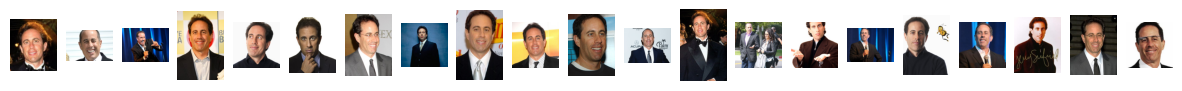

In [7]:
import matplotlib.pyplot as plt #Matplot za prikazivanje slika
import os

# Putanja do foldera sa slikama radi prikaza
folder_path = '/content/Material/train/jerry_seinfeld'

# Svaki fajl unutar foldera (list dir) se proverava, i ukoliko je stvarno fajl (a ne folder), dodaje se na putanju foldera i kao rezultat dobijamo niz imena fajlova za dalji prikaz
#npr. *putanja*/slika1.jpg, *putanja*/slika2.jpg
image_files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

# Postavljanje veličine grafa
fig, axes = plt.subplots(1, len(image_files), figsize=(15, 5))  # 1 red, broj kolona koliko imamo slika, veličina 15x5 inch-a

# Za svaku sliku...
for i, image_file in enumerate(image_files):
    image_path = os.path.join(folder_path, image_file)

    # Učitaj sliku na osnovu putanje foldera + putanje slike
    image = plt.imread(image_path)

    axes[i].imshow(image)
    axes[i].axis('off')

plt.show()

## DeepFace
"Deep Face" model se obično odnosi na specifičan model za prepoznavanje lica, posebno popularan u detekciji i prepoznavanju lica u fotografijama. Najpoznatiji Deep Face model je razvijen od strane Facebook AI Research (FAIR) tima 2014. godine.

Ovaj model koristi duboke neuronske mreže, posebno konvolucijske neuronske mreže (CNN), kako bi izvršio detekciju i prepoznavanje lica na slikama. Originalni Deep Face model se sastoji od nekoliko slojeva konvolucijskih i potpuno povezanih slojeva, obučenih na velikom broju lica kako bi postigao visok nivo tačnosti.

24-03-14 17:00:37 - Directory /root/.deepface created
24-03-14 17:00:37 - Directory /root/.deepface/weights created


Action: gender:   0%|          | 0/3 [00:00<?, ?it/s] 

24-03-14 17:00:41 - gender_model_weights.h5 will be downloaded...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/gender_model_weights.h5
To: /root/.deepface/weights/gender_model_weights.h5

  0%|          | 0.00/537M [00:00<?, ?B/s]
  0%|          | 1.05M/537M [00:00<01:01, 8.77MB/s]
  0%|          | 2.62M/537M [00:00<00:44, 12.0MB/s]
  1%|          | 4.72M/537M [00:00<00:35, 15.1MB/s]
  1%|▏         | 7.34M/537M [00:00<00:27, 19.0MB/s]
  2%|▏         | 11.5M/537M [00:00<00:20, 26.2MB/s]
  3%|▎         | 17.3M/537M [00:00<00:14, 36.2MB/s]
  5%|▍         | 25.2M/537M [00:00<00:10, 49.2MB/s]
  7%|▋         | 35.1M/537M [00:00<00:07, 64.0MB/s]
  9%|▉         | 49.3M/537M [00:00<00:05, 86.7MB/s]
 12%|█▏        | 66.6M/537M [00:01<00:04, 112MB/s] 
 16%|█▌        | 86.0M/537M [00:01<00:03, 135MB/s]
 20%|█▉        | 107M/537M [00:01<00:02, 157MB/s] 
 24%|██▍       | 129M/537M [00:01<00:02, 175MB/s]
 27%|██▋       | 147M/537M [00:01<00:02, 177MB/s]
 32%|███▏      | 169M/537M [00:01<00:01, 189MB/s]
 36%|███▌      | 191

24-03-14 17:00:53 - age_model_weights.h5 will be downloaded...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/age_model_weights.h5
To: /root/.deepface/weights/age_model_weights.h5

  0%|          | 0.00/539M [00:00<?, ?B/s]
  0%|          | 1.05M/539M [00:00<00:57, 9.38MB/s]
  1%|          | 3.15M/539M [00:00<00:37, 14.4MB/s]
  1%|          | 6.29M/539M [00:00<00:25, 20.7MB/s]
  2%|▏         | 11.0M/539M [00:00<00:17, 29.8MB/s]
  3%|▎         | 17.8M/539M [00:00<00:12, 42.3MB/s]
  5%|▌         | 28.3M/539M [00:00<00:08, 62.3MB/s]
  8%|▊         | 43.5M/539M [00:00<00:05, 90.1MB/s]
 12%|█▏        | 66.1M/539M [00:00<00:03, 132MB/s] 
 17%|█▋        | 90.7M/539M [00:00<00:02, 166MB/s]
 21%|██        | 112M/539M [00:01<00:02, 181MB/s] 
 24%|██▍       | 131M/539M [00:01<00:02, 180MB/s]
 28%|██▊       | 151M/539M [00:01<00:02, 187MB/s]
 32%|███▏      | 172M/539M [00:01<00:01, 195MB/s]
 36%|███▌      | 192M/539M [00:01<00:02, 170MB/s]
 39%|███▉      | 210M/539M [00:01<00:01, 168MB/s]
 42%|████▏     | 228M/539M [00

24-03-14 17:01:09 - facial_expression_model_weights.h5 will be downloaded...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/facial_expression_model_weights.h5
To: /root/.deepface/weights/facial_expression_model_weights.h5

  0%|          | 0.00/5.98M [00:00<?, ?B/s]
 18%|█▊        | 1.05M/5.98M [00:00<00:00, 8.96MB/s]
 44%|████▍     | 2.62M/5.98M [00:00<00:00, 12.4MB/s]
100%|██████████| 5.98M/5.98M [00:00<00:00, 16.7MB/s]
Action: emotion: 100%|██████████| 3/3 [00:32<00:00, 10.84s/it]


[{'gender': {'Woman': 0.014717626618221402, 'Man': 99.98527765274048}, 'dominant_gender': 'Man', 'region': {'x': 10, 'y': 32, 'w': 75, 'h': 75, 'left_eye': None, 'right_eye': None}, 'face_confidence': 0.9, 'age': 25, 'emotion': {'angry': 0.3704034024849534, 'disgust': 0.0003766853296838235, 'fear': 0.6428622640669346, 'happy': 0.043490788084454834, 'sad': 26.291581988334656, 'surprise': 0.003767077942029573, 'neutral': 72.64752388000488}, 'dominant_emotion': 'neutral'}]


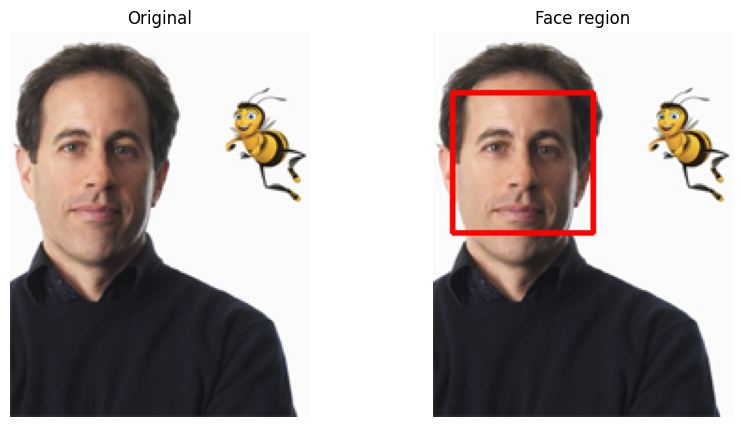

In [8]:
import cv2 #Za rad sa slikama i prosleđivanje modelu
from deepface import DeepFace

# Originalna slika
original_img = cv2.imread('/content/Material/train/jerry_seinfeld/httpimagesrottentomatoescomimagesspotlightsnewsjerryseinfeldjpg.jpg')

# Kopija slike za prikaz regije koju deepface detektuje kao lice
img_with_region = original_img.copy()

results = DeepFace.analyze(img_with_region, actions=["gender", "age", "emotion"]) #Deepface.analyze funkcija može odrediti
              # pol, starost, emociju i rasu osobe na slici, za potrebe zadatka potrebno je samo prva 3 atributa
print(results)
# Na osnovu rezultata funkcije, definišemo region pravougaonika
region = results[0]['region']
x, y, w, h = region['x'], region['y'], region['w'], region['h']

# Nacrtaj pravougaonik
cv2.rectangle(img_with_region, (x, y), (x + w, y + h), (0, 0, 255), 2)  # BGR

# 1 red, 2 kolone
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Prikaz originalne slike
axes[0].imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)) #CV2 Biblioteka radi sa slikama u BGR spektru, dok je originalna slika u RGB spektru
axes[0].axis('off')
axes[0].set_title('Original')

axes[1].imshow(cv2.cvtColor(img_with_region, cv2.COLOR_BGR2RGB))
axes[1].axis('off')
axes[1].set_title('Face region')

plt.show()

Action: gender: 100%|██████████| 3/3 [00:01<00:00,  1.72it/s]


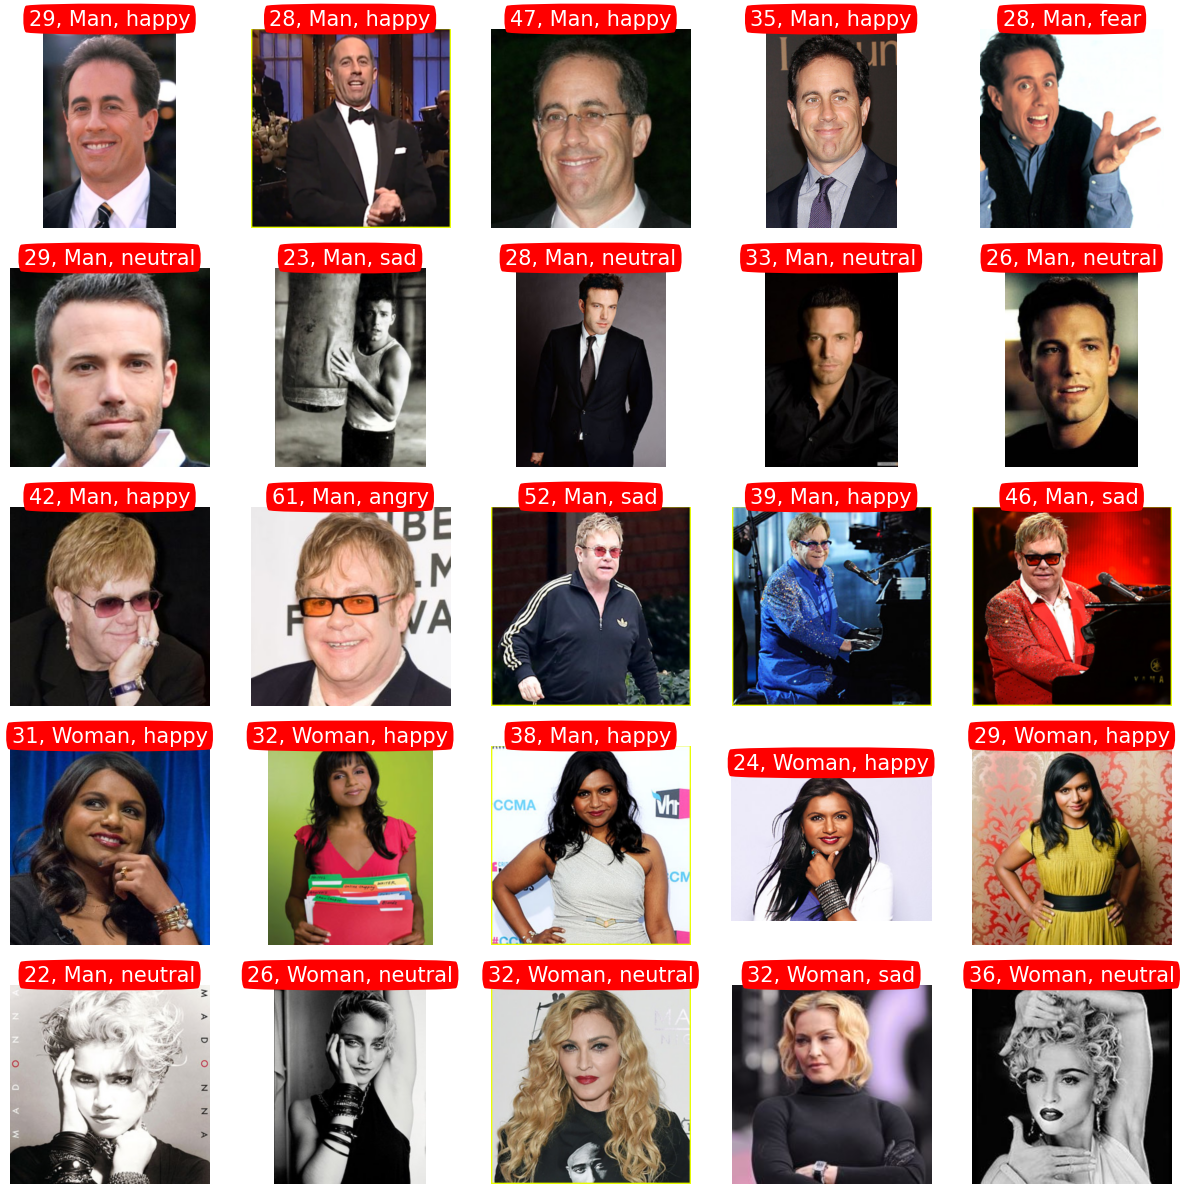

In [12]:
from deepface import DeepFace
import cv2
import matplotlib.pyplot as plt
from glob import glob

# Lista svih slika unutar validation foldera
image_files = glob('/content/Material/val/**/*.jpg', recursive=True)

num_columns = 5 #5 redova za 25 slika
num_rows = 5 #5 kolona

fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 15)) #15x15 inch-a

j = 0

#Za svaku putanju slike..
for img_file in image_files:
    img = cv2.cvtColor(cv2.imread(img_file), cv2.COLOR_BGR2RGB) #Učitaj sliku u originalnoj boji radi prikaza na grafu

    img_h, img_w, _ = img.shape #Sa obzirom da je sada slika učitana kao numpy niz, prva vrednost je visina, druga je širina, treća je spektar boje (- ignoriše spektar boje, zato što je već podešen)
    r = 640 / max(img_h, img_w) #Standardizacija veličine slike (u ovom koraku se pamti razmera rezolucije,
    # slika se standardizuje tako da pre prosleđivanja modelu slike budu iste veličine)
    img = cv2.resize(img, (int(img_w * r), int(img_h * r)))

    results = DeepFace.analyze(img_file, actions=['age', 'emotion', 'gender'], enforce_detection=False) #Ukoliko deepface ne može detektovati lice, izvršavanje se nastavlja.

    #Prvi rezultat u nizu predstavlja rezultat predikcije za trenutnu sliku u iteraciji, pristupamo vrednostima koje smo dobili
    predicted_gender = results[0]['dominant_gender']
    predicted_age = results[0]['age']
    predicted_emotion = results[0]['dominant_emotion']

    # Kreiranje labele radi prikaza rezultata
    label = "{}, {}, {}".format(int(predicted_age), predicted_gender, predicted_emotion)

    text_x = j // num_columns
    text_y = j % num_columns

    #Tekst i pozadinska boja
    axes[text_x, text_y].text(
        0.5, 1.05, label, fontsize=15, color='white',
        bbox=dict(facecolor='red', alpha=1, edgecolor='none', boxstyle='round4'),
        transform=axes[text_x, text_y].transAxes, ha='center', va='center'
    )
    axes[text_x, text_y].imshow(img)
    axes[text_x, text_y].axis('off')
    j += 1

plt.show()


# Zaključak

In [14]:
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator

model = load_model('gender_detection_model.h5')

test_datagen = ImageDataGenerator(rescale=1./255) #Normalizacija slika

test_generator = test_datagen.flow_from_directory(
    '/content/Material/val',
    target_size=(224, 224),
    batch_size=3,
    class_mode='binary',
    shuffle=False
)

eval_result = model.evaluate(test_generator)

accuracy = eval_result[1]

print(f'Accuracy: {accuracy * 100:.2f}%')

Found 25 images belonging to 5 classes.
9/9 [==============================] - 16s 2s/step - loss: -7.6376 - accuracy: 0.2000
Accuracy: 20.00%


In [15]:
from deepface import DeepFace
import os
from glob import glob


test_dir = '/content/Material/val'

correct_predictions = 0
total_images = 0

for image_file in glob('/content/Material/val/**/*.jpg', recursive=True):
    image_path = os.path.join(test_dir, image_file)

    results = DeepFace.analyze(image_path, actions=['gender'], enforce_detection=False)

    predicted_gender = results[0]['dominant_gender']

    actual_gender = 'Man' if 'male' == os.path.basename(os.path.dirname(image_path)).lower() else 'Woman'

    correct_prediction = predicted_gender.lower() == actual_gender.lower()
    if correct_prediction:
        correct_predictions += 1

    total_images += 1

accuracy = (correct_predictions / total_images) * 100
print(correct_predictions)
print(total_images)
print(f"Accuracy: {accuracy:.2f}%")


8
25
Accuracy: 32.00%


Prema rezultatima tačnosti modela može se zaključiti da DeepFace model ima veću tačnost nego model kreiran u sekciji Praktičan dio.


---

Moguće je zaključiti, takođe, da i razni uticaji poput kvaliteta slike koja se testira, mogu imati efekat na tačnost modela. Zavisnost od kvaliteta i ugla slike, odnosno regije koju algoritam detektuje može dovesti do problema pri određivanju starosti i emocije.